# Appendix A: 
## Data Loading and Exploration 

ADS 599 Capstone: NLP + Machine Learning Techniques to Identifying Fake Job Postings

Team 2:
* Brianne Bell 
* Zachariah Freitas

In [5]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import os
import re
import random
import time
import datetime
import missingno

import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec # to do the grid of plots

%matplotlib inline

# Load Data and Review
Loading up the original data from Kaggle.

In [6]:
file_path = '../Data Folder/fake_job_postings.csv'
raw_df = pd.read_csv(file_path)
print('Raw Data Shape: ')
print(raw_df.shape)
print('\nColumns in the raw data:')
print(raw_df.columns)

Raw Data Shape: 
(17880, 18)

Columns in the raw data:
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [7]:
# example of data contents
raw_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


There are 18 columns, one of which is the outcome called fraudulent.
There are 17,880 entries, but there are null entries throughout. 

# Duplicates

In [8]:
# Count the number of dubplicated rows.
n = len(raw_df)-len(raw_df.drop_duplicates())

print("No. of duplicated rows :", n)

No. of duplicated rows : 0


In [9]:
# check the cardinality for each column
n = raw_df.nunique(axis=0)
  
print(f"No. of unique values in each column :\n{n}")

No. of unique values in each column :
job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64


There are no duplicated rows in the data.

job_id appears to have no value in this analysis and is an id associated with the posting, not controled by the poster.

In [10]:
# Let's check the number of duplicated rows in the dataset after removing the job_id column.
n = len(raw_df.loc[:, raw_df.columns!='job_id'])-len(raw_df.loc[:, raw_df.columns!='job_id'].drop_duplicates())

print("No. of duplicated rows :", n)

No. of duplicated rows : 281


In [11]:
dd_raw_df = raw_df.loc[:, raw_df.columns!='job_id'].drop_duplicates()

print("Undeduplicated Data Shape: ")
print(raw_df.fraudulent.value_counts())

print("\nDeduplicated Data Shape: ")
print(dd_raw_df.fraudulent.value_counts())

Undeduplicated Data Shape: 
0    17014
1      866
Name: fraudulent, dtype: int64

Deduplicated Data Shape: 
0    16743
1      856
Name: fraudulent, dtype: int64


Most of the duplicated rows are in the non-fraudulent group. 
I think we can safely drop duplicated rows and job_id from our dataset.

# Missing Data

In [12]:
# looking at what is null
print(dd_raw_df.isnull().sum().sort_values(ascending=False))
print('\nTotal number of null values: ', dd_raw_df.isnull().sum().sum())


salary_range           14772
department             11328
required_education      8009
benefits                7106
required_experience     6962
function                6363
industry                4837
employment_type         3428
company_profile         3282
requirements            2648
location                 341
description                1
title                      0
telecommuting              0
has_questions              0
has_company_logo           0
fraudulent                 0
dtype: int64

Total number of null values:  69077


<AxesSubplot: >

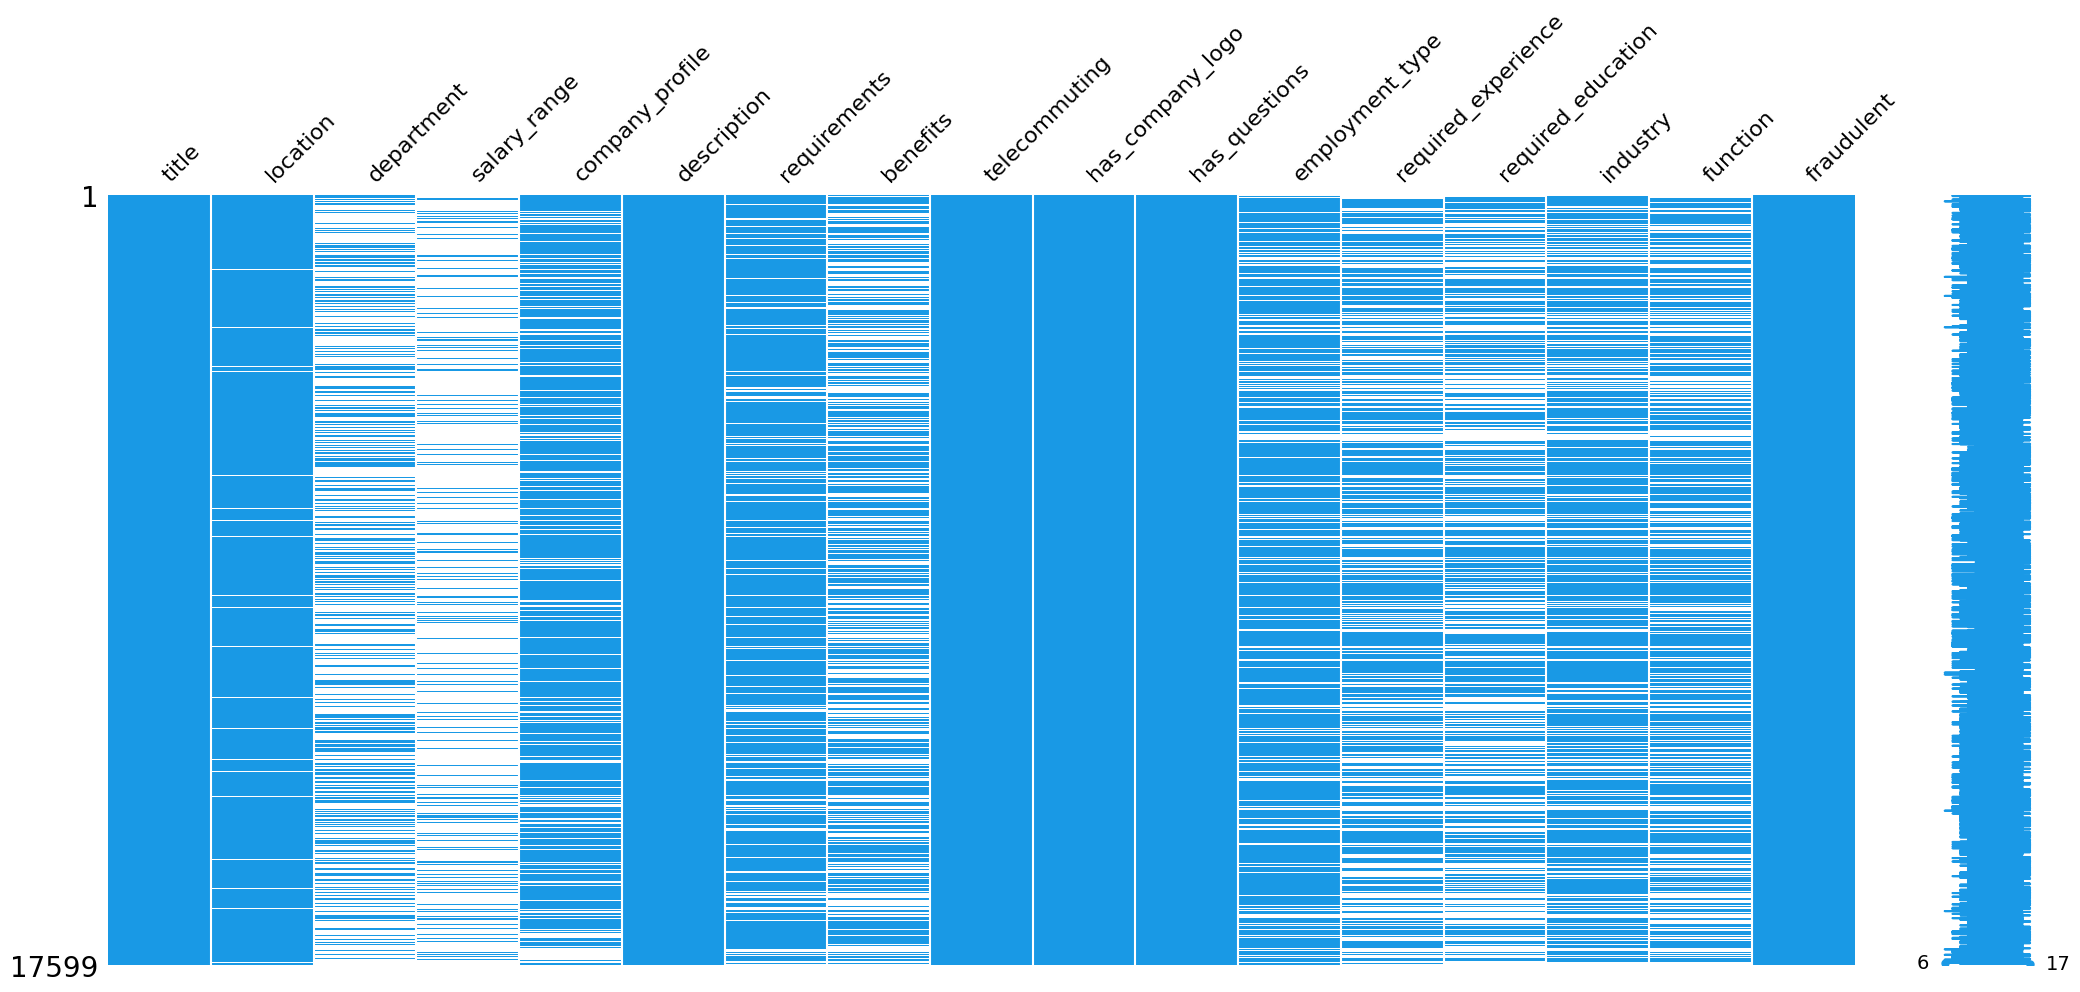

In [13]:
# checking missing data in our dataframe.
missingno.matrix(dd_raw_df,color=(0.1, 0.6, 0.9))

Columns with no missing data:
* job_id
* title
* telecommuting
* has_company_logo
* has_questions
* fraudulent

The description field is only missing one entry.

job_id appears to have no value and is an id associated with the posting, not controled by the poster.

The largest amount of missing entries is in salary_range followed by department. 

We note a total of 70,103 null values occuring across all features.

In [14]:
# looking at what is null when fraudulent is 1
print(dd_raw_df[dd_raw_df['fraudulent']==1].shape)
print(dd_raw_df[dd_raw_df['fraudulent']==1].isnull().sum().sort_values(ascending=False))
print('\nTotal number of null values: ', dd_raw_df[dd_raw_df['fraudulent']==1].isnull().sum().sum())

(856, 17)
salary_range           635
company_profile        580
department             524
required_education     444
required_experience    427
benefits               359
function               330
industry               270
employment_type        236
requirements           151
location                19
description              1
title                    0
telecommuting            0
has_questions            0
has_company_logo         0
fraudulent               0
dtype: int64

Total number of null values:  3976


<AxesSubplot: >

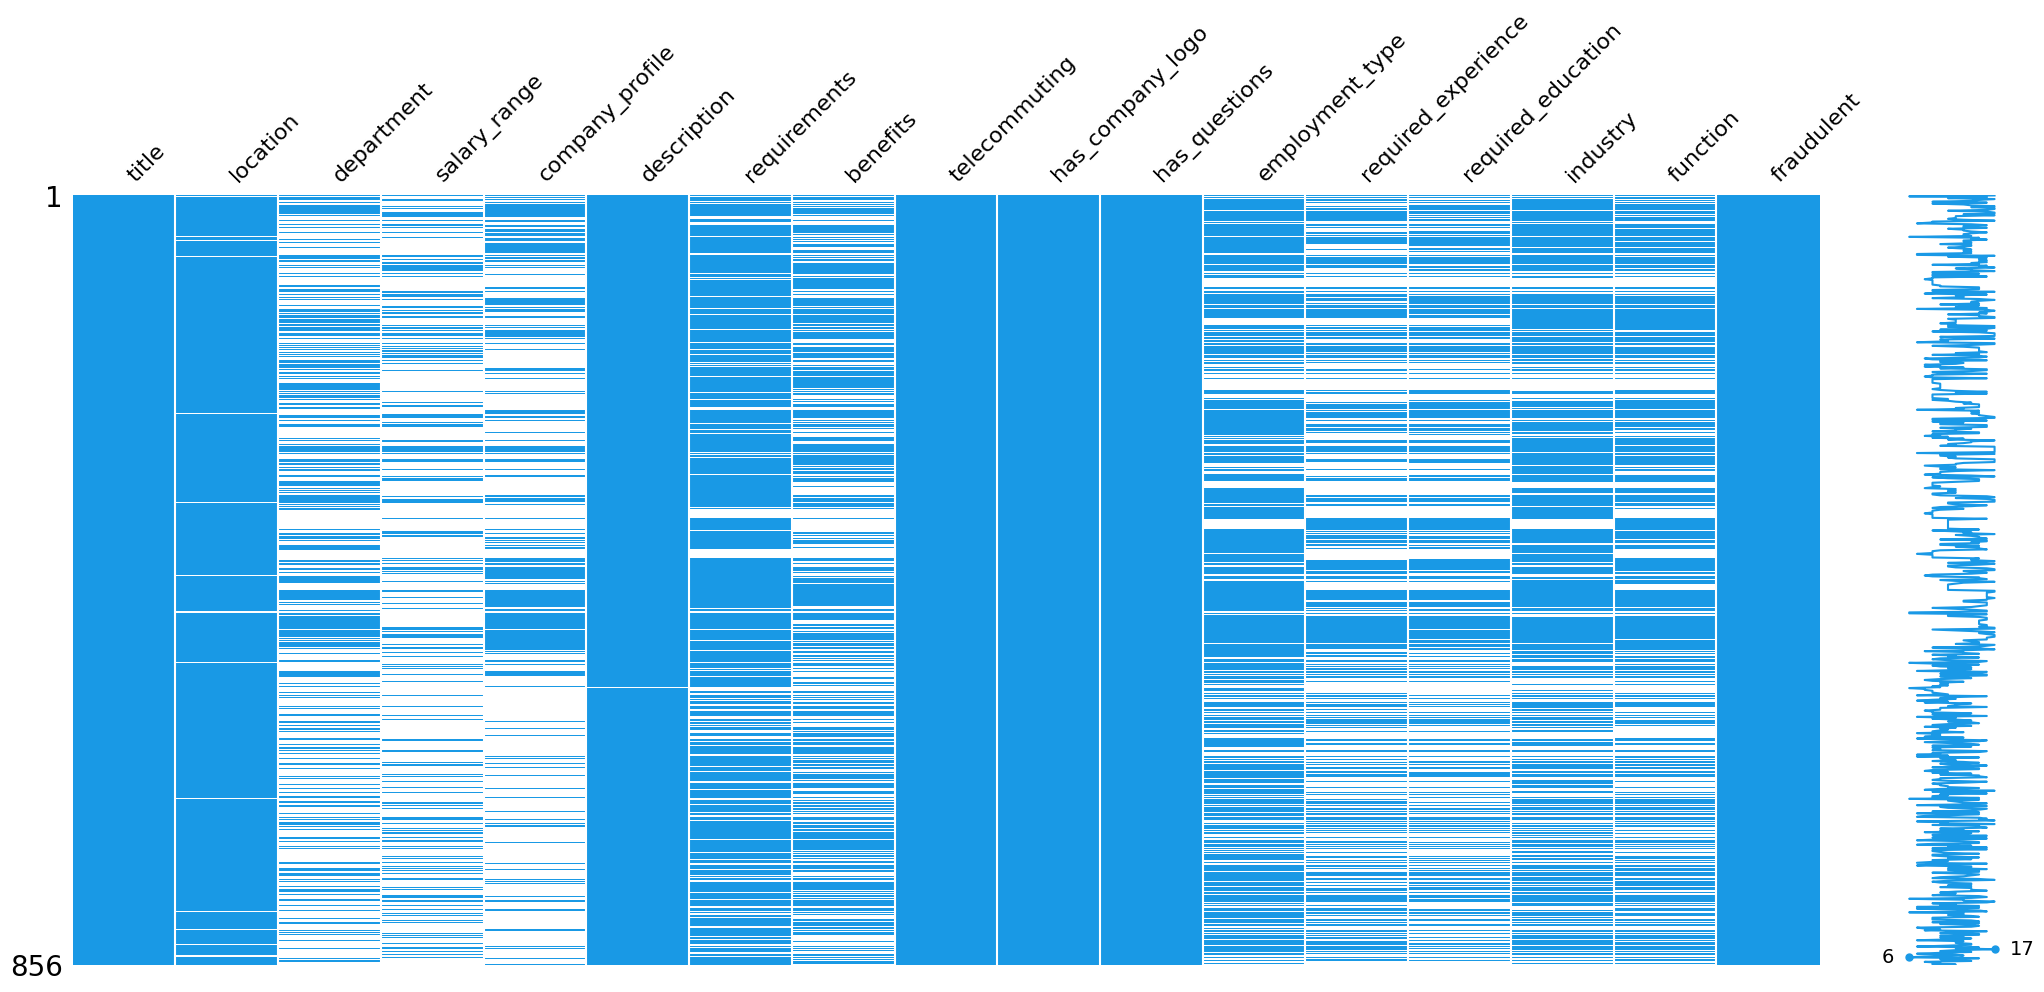

In [15]:
# checking missing data in our dataframe when fraudulent is 1
missingno.matrix(dd_raw_df[dd_raw_df['fraudulent']==1],color=(0.1, 0.6, 0.9))

# Bivariate EDA
## Correlation Analysis

In [16]:
dd_raw_df.corr()

C:\Users\zfreitas\AppData\Local\Temp\ipykernel_15036\339301835.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dd_raw_df.corr()


,telecommuting,has_company_logo,has_questions,fraudulent
telecommuting,1.000000,-0.021359,0.019094,0.035644
has_company_logo,-0.021359,1.000000,0.233755,-0.259868
has_questions,0.019094,0.233755,1.000000,-0.090966
fraudulent,0.035644,-0.259868,-0.090966,1.000000


# Pairplots

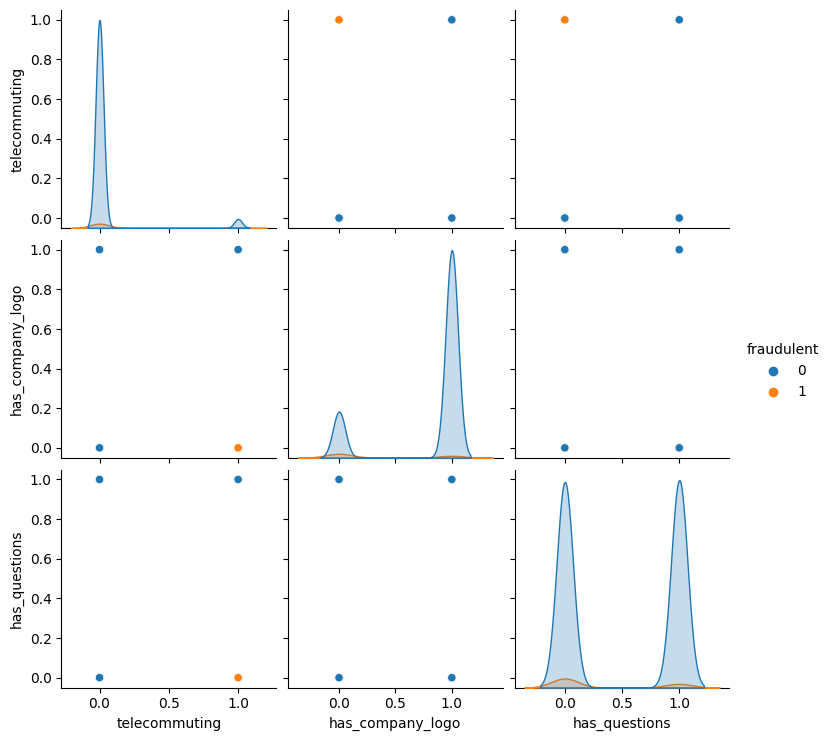

In [17]:
# Pairplot of the data
sns.pairplot(dd_raw_df, hue = 'fraudulent')

# Look at Balance

In [18]:
categorical_variables = list(dd_raw_df.select_dtypes('object').columns)

numeric_variables = list(dd_raw_df.select_dtypes(['float64','int64']).columns)
numeric_variables.remove('fraudulent')

target = 'fraudulent'

print(f'Categorical Variables ({len(categorical_variables)}):\n{categorical_variables}\n\nNumeric Variables ({len(numeric_variables)}):\n{numeric_variables}\n\nTarget:\n{target}')

Categorical Variables (13):
['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

Numeric Variables (3):
['telecommuting', 'has_company_logo', 'has_questions']

Target:
fraudulent


In [19]:
dd_raw_df.fraudulent.value_counts()

0    16743
1      856
Name: fraudulent, dtype: int64

In [20]:

class AutoEdaBinaryClassif():
    def __init__(self):
        pass
    
    
    def primary_eda(self,data):
        '''
        This method returns head, shape,data types of variables 
        and summary statistics of input data frame.
        
        params:
        data: input data frame.
        
        Returns: None.
        
        '''
        data = data.copy()
        print("First few records")
        display(data.head().T)
        shape = data.shape
        print(f'Dataset has {shape[0]} records/rows and {shape[1]} features/columns\n')
        data_types = data.dtypes
        data_types = [f'{i}: {j}' for i, j in zip(list(data_types.index), list(data_types.astype('str')))]
        print(f'Data types: {data_types}\n\n\nSummary of numeric variables:')
        display(data.describe().T)
        print(f'Summary of categorical variables:')
        display(data.describe(include='object').T)
    
    
    def missing_value_summary(self, data, show_plot=True, plot_width=8, plot_height=8):
        '''
        This method returns missing value summary of an input data frame and also
        plots a heatmap of the missing values across columns and indices.
        
        params:
        data: input data frame.
        show_plot: boolean to disply the missing value plot, default value = True
        plot_width: width of the heatmap, default value = 8.
        plot_height: height of the heatmap, default value = 8.
        
        Returns: Data frame with missing value summary.
        
        '''
        data = data.copy()
        miss_val_cnt = data.isnull().sum().astype('int')
        miss_val_per = np.round((miss_val_cnt / len(data)) * 100,2)
        missing_value_summary = pd.concat([miss_val_cnt,miss_val_per],axis=1).reset_index()
        missing_value_summary.columns = ['column', 'missing_count', 'missing_percent']
        miss_str = missing_value_summary.copy()
        miss_str['column'] = miss_str['column'] + ':'
        miss_str['missing_percent'] = '(' + miss_str['missing_percent'].astype('str') + '%)'
        miss_str = "; ".join(miss_str.apply(lambda x: ''.join([str(i) for i in list(x)]),axis=1))
        print(f'Missing values: Format- column:count(percent)\n\n{miss_str}')
        if show_plot == True:
            miss_val_mark = data.isnull()
            fig = plt.figure(figsize=(plot_width, plot_height))
            sns.heatmap(miss_val_mark,cbar=False)
            plt.title('Missing values')
            plt.show()
        return missing_value_summary
    
    
    def class_separation(self, data, categorical_variables, method='pca', plot_alpha=0.5):
        '''
        This method uses 2-D scatter plot to visualize the class separation 
        by reducing the data dimensions to 2, using PCA/SVD.
        
        params:
        data: input data frame.
        categorical_variables: list containing categorical variable/column names of 'data'.
        method: technique to be used for dimensionality reduction. Takes two values 'pca' or 'svd'.
        default value = 'pca'
        plot_alpha: specifies the transparency of the markers in the scatter plot.
        default value = 0.5.
        
        Returns: None.
        
        '''
        categorical_variables = categorical_variables.copy()
        data = data.copy()
        data = data.dropna().copy()
        print(f'{len(data)} examples remaining after dropping examples with NaN')
        X = data.iloc[:,:-1].copy()
        y = LabelEncoder().fit_transform(data['target']).copy()
        
        if method == 'pca':
            col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
                                                             OrdinalEncoder(),
                                                             categorical_variables]],
                                              remainder='passthrough')

            X = col_transform.fit_transform(X).copy()
            min_max = MinMaxScaler()
            X = min_max.fit_transform(X).copy()

            pca = PCA(n_components=2,random_state=11)
            X_pca = pca.fit_transform(X).copy()
            X_pca = pd.DataFrame(X_pca,columns=["component_1","component_2"])
            X_pca['y'] = y

            print(f'Total explained variance ratio: {np.cumsum(pca.explained_variance_ratio_)[-1]}\nTotal explained variance ratio less than 0.6 may not be reliable')
            
            fig = plt.figure(figsize=(8,8))
            sns.scatterplot(data=X_pca,x='component_1',y="component_2",hue='y',alpha=plot_alpha);
        else:
            col_transform = ColumnTransformer(transformers=[['ohe',
                                                             OneHotEncoder(),
                                                             categorical_variables]],
                                              remainder='passthrough')

            X = col_transform.fit_transform(X).copy()
            max_abs = MaxAbsScaler()
            X = max_abs.fit_transform(X).copy()

            tsvd = TruncatedSVD(n_components=2,random_state=11)
            X_svd = tsvd.fit_transform(X).copy()
            X_svd = pd.DataFrame(X_svd,columns=["component_1","component_2"])
            X_svd['y'] = y

            print(f'Total explained variance ratio: {np.cumsum(tsvd.explained_variance_ratio_)[-1]}\nTotal explained variance ratio less than 0.6 may not be reliable')
            
            fig = plt.figure(figsize=(8,8))
            sns.scatterplot(data=X_svd,x='component_1',y="component_2",hue='y',alpha=plot_alpha);

            
    def density_plots(self, data, numeric_variables, plot_width = 15, plot_height = 20):
        '''
        This method displays the KDE plots of the numeric variables in a data frame.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        plot_width: width of the plot, default value = 15.
        plot_height: height of the plot, default value = 20.
        
        Returns: None
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        numeric_variables_length = len(numeric_variables)
        rows_in_plot = int(numeric_variables_length / 2) if (numeric_variables_length % 2 == 0) else (int(numeric_variables_length / 2) + 1)
        data[numeric_variables].plot(kind='kde', figsize=(plot_width, plot_height), subplots=True, layout=(rows_in_plot,2),sharex = False, sharey = False, color='black');
        
    
    def cdf(self, data, numeric_variables, plot_width=15, plot_height=20):
        data = data.copy()
        numeric_variables = numeric_variables.copy()
            
        r = c = 0
        numeric_variables_length = len(numeric_variables)
        rows_in_plot = int(numeric_variables_length / 2) if (numeric_variables_length % 2 == 0) else (int(numeric_variables_length / 2) + 1)
        fig,ax = plt.subplots(rows_in_plot,2,figsize=(plot_width, plot_height))
        
        if rows_in_plot > 1:
            for n,i in enumerate(numeric_variables):
                val_cnts = np.round(data[i].value_counts(normalize=True),3).sort_index().copy()
                val_cnts = val_cnts.cumsum().copy()
                val_cnts.plot(kind='line',ax=ax[r,c],title=f'CDF of {i}',color='black',xlabel=i,ylabel='cdf')
                ax[r,c].yaxis.grid(color='lightgray', linestyle='dashed')
                ax[r,c].xaxis.grid(color='lightgray', linestyle='dashed')
                c+=1
                if (n+1)%2==0:
                    r+=1
                    c=0
            if (numeric_variables_length % 2) != 0:
                ax[r,c].axis("off")
        else:
            for n,i in enumerate(numeric_variables):
                val_cnts = np.round(data[i].value_counts(normalize=True),3).sort_index().copy()
                val_cnts = val_cnts.cumsum().copy()
                val_cnts.plot(kind='line',ax=ax[n],title=f'CDF of {i}',color='black',xlabel=i,ylabel='cdf')
                ax[n].yaxis.grid(color='lightgray', linestyle='dashed')
                ax[n].xaxis.grid(color='lightgray', linestyle='dashed')
                c+=1
                if (n+1)%2==0:
                    r+=1
                    c=0
            if numeric_variables_length == 1:
                ax[1].axis('off')
        plt.show()
        
        
    
    
    def normality_test(self, data, numeric_variables):
        '''
        This method performs a test for normality using 'normaltest' function of scipy.stats module.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        
        Returns: None
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        print("The test for normality is performed using 'normaltest' function of scipy.stats\n\nSignificance Level (alpha) : 0.05\n\n" +
        "h0:Sample comes from a normal distribution\nh1:Sample doesn't come from a normal distribution\n\n")
        for i in numeric_variables:
            print(f"{i}: {'Non-Gaussian' if (stats.normaltest(data[i])[1])<0.05 else 'Gaussian'}  {stats.normaltest(data[i])}")
       
    
    def qqplots(self, data, numeric_variables):
        '''
        This method displays the Q-Q plots of the specified numeric variables in the input data frame.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        
        Returns: None.
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        for n,i in enumerate(numeric_variables):
            stats.probplot(data[i],plot=plt)
            plt.title(i)
            plt.show()
           
        
    def boxplots(self, data, numeric_variables, plot_width=15, plot_height=20):
        '''
        This method displays the box plots of the specified numeric variables in a data frame.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        plot_width: width of the plot, default value = 15.
        plot_height: height of the plot, default value = 20.
        
        Returns: None.
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        numeric_variables_length = len(numeric_variables)
        rows_in_plot = int(numeric_variables_length / 2) if (numeric_variables_length % 2 == 0) else (int(numeric_variables_length / 2) + 1)
        data[numeric_variables].plot(kind='box',subplots=True,layout=(rows_in_plot,2),figsize=(plot_width, plot_height), color='black');
        
        
    def skewness_test(self, data, numeric_variables):
        '''
        This method performs a test for skewness and also displays the skewness value.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        
        Returns: None
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        for i in numeric_variables:
            print(f"{i}: {'Skewed' if (stats.skewtest(data[i])[1])<0.05 else 'Not Skewed'}  {stats.skew(data[i])}")
            
    
    def feature_correlation(self, data, numeric_variables, corr_matrix_width = 10, corr_matrix_height = 10, plot = True, plot_width = 10, plot_height = 10):
        '''
        This method displays the Pearson & Kendall rank correlation coefficients of the specified
        numeric features of the input data frame. The correlation coefficients are displayed using 
        seaborn' heatmap.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        corr_matrix_width: width of correlation heatmaps, default value = 10.
        corr_matrix_height: height of correlation heatmaps, default value = 10.
        plot: boolean to control the display of pairplots, default value = True.
        plot_width: width of pair plot, default value = 10.
        plot_height: height of pair plot, default value = 10.
        
        Returns: None.
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        fig = plt.figure(figsize=(corr_matrix_width, corr_matrix_height))
        sns.heatmap(data[numeric_variables].corr(method='pearson'),mask=np.triu(data[numeric_variables].corr()),
                    annot=True,fmt='.2f',
                    cbar=False,cmap=['white'],linewidths=0.01,linecolor='black',square=True)
        plt.title('Pearson correlation')
        plt.show();
        
        fig = plt.figure(figsize=(corr_matrix_width, corr_matrix_height))
        sns.heatmap(data[numeric_variables].corr(method='kendall'),mask=np.triu(data[numeric_variables].corr()),
                    annot=True,fmt='.2f',
                    cbar=False,cmap=['white'],linewidths=0.01,linecolor='black',square=True)
        plt.title('Kendall rank correlation')
        plt.show();
        
        if plot == True:
            fig = plt.figure(figsize=(plot_width, plot_height))
            sns.pairplot(data[numeric_variables])
            plt.show();
            
        
    
    def numeric_variables_vs_target(self, data, numeric_variables, target, plot_width=15, plot_height=20):
        '''
        This method plots violin plots of specified numeric variables vs target variable.
        
        params:
        data: input data frame.
        numeric_variables: list containing numeric variable/column names of 'data'.
        target: string specifying the name of target variable.
        plot_width: width of pair plot, default value = 15.
        plot_height: height of pair plot, default value = 20.
        
        Returns: None.
        
        '''
        numeric_variables = numeric_variables.copy()
        data = data.copy()
        r = c = 0
        numeric_variables_length = len(numeric_variables)
        rows_in_plot = int(numeric_variables_length / 2) if (numeric_variables_length % 2 == 0) else (int(numeric_variables_length / 2) + 1)
        fig,ax = plt.subplots(rows_in_plot,2,figsize=(plot_width, plot_height))
        
        if rows_in_plot > 1:
            for n,i in enumerate(numeric_variables):
                med = data[[i,target]].groupby(target).median().copy()
                sns.violinplot(x=target,y=i,data=data,ax=ax[r,c],palette=["gray","lightgray"])
                med.plot(ax=ax[r,c],color='black',linewidth=3,linestyle="--",legend=False)
                for x,y in zip(list(med.index),med[i]):
                    ax[r,c].text(x=x+0.05,y=y+0.01,s=np.round(y,2),fontsize=10,color='white',backgroundcolor='black')
                ax[r,c].set_title(i.upper()+" by "+target)
                c+=1
                if (n+1)%2==0:
                    r+=1
                    c=0
            if (numeric_variables_length % 2) != 0:
                ax[r,c].axis("off")
        else:
            for n,i in enumerate(numeric_variables):
                med = data[[i,target]].groupby(target).median().copy()
                sns.violinplot(x=target,y=i,data=data,ax=ax[c],palette=["gray","lightgray"])
                med.plot(ax=ax[c],color='black',linewidth=3,linestyle="--",legend=False)
                for x,y in zip(list(med.index),med[i]):
                    ax[c].text(x=x+0.05,y=y+0.01,s=np.round(y,2),fontsize=10,color='white',backgroundcolor='black')
                ax[c].set_title(i.upper()+" by "+target)
                c+=1
                if (n+1)%2==0:
                    r+=1
                    c=0
            if numeric_variables_length == 1:
                ax[1].axis('off')
        plt.show()
        
        
    def categorical_variable_distribution(self, data, categorical_variables, plot=True, vars_to_exclude_from_plots=[], plot_width=10, plot_height=10):
        categorical_variables = categorical_variables.copy()
        data = data.copy()
        data = data.fillna('NaN/Missing').copy()
        for i in categorical_variables:
            val_cnt = pd.DataFrame(np.round(data[i].value_counts(normalize=True)*100,2))
            val_cnt.columns = ['Proportion']
            n_unique = data[i].nunique()
            excl_str = ""
            if 'NaN/Missing' in list(val_cnt.index):
                n_unique -= 1
                excl_str = "(excluding 'NaN/Missing')"
            print(f"{i}: {n_unique} unique categories{excl_str}\n{val_cnt}\n\n")
            
            
        if plot == True:
            categorical_variables = categorical_variables.copy()
            data = data.copy()
            for rem in vars_to_exclude_from_plots:
                categorical_variables.remove(rem)
            r = c = 0
            variables_length = len(categorical_variables)
            rows_in_plot = int(variables_length / 2) if (variables_length % 2 == 0) else (int(variables_length / 2) + 1)
            fig,ax = plt.subplots(rows_in_plot,2,figsize=(plot_width, plot_height))

            if rows_in_plot > 1:
                for n,i in enumerate(categorical_variables):
                    cat_dist = data[i].value_counts().sort_values().copy()
                    cat_dist = np.round((cat_dist / cat_dist.sum()) * 100,1).copy()
                    cat_dist.plot(kind="barh",ax=ax[r,c],sharey=False,title=i,color='black')
                    for x,y in enumerate(list(cat_dist.index)):
                        ax[r,c].text(y=x-0.02,x=cat_dist[y],s=f'{np.round(cat_dist[y],2)}%')
                    ax[r,c].set_title(i)
                    c+=1
                    if (n+1)%2==0:
                        r+=1
                        c=0
                if (variables_length % 2) != 0:
                    ax[r,c].axis("off")
            else:
                for n,i in enumerate(categorical_variables):
                    cat_dist = data[i].value_counts().sort_values().copy()
                    cat_dist = np.round((cat_dist / cat_dist.sum()) * 100,1).copy()
                    cat_dist.plot(kind="barh",ax=ax[n],sharey=False,title=i,color='black')
                    for x,y in enumerate(list(cat_dist.index)):
                        ax[n].text(y=x-0.02,x=cat_dist[y],s=f'{np.round(cat_dist[y],2)}%')
                    ax[n].set_title(i)
                    c+=1
                    if (n+1)%2==0:
                        r+=1
                        c=0
                if variables_length == 1:
                    ax[1].axis('off')
            plt.show()
            
            
    def categorical_variables_vs_target(self, data, categorical_variables, target, crosstabs=True, crosstab_show_missing=False, crosstab_proportion=True, col_proportion=True, plots=True, vars_to_exclude_from_plots=[],plot_width=15,plot_height=20):
        categorical_variables = categorical_variables.copy()
        data = data.copy()
        categorical_variables = categorical_variables.copy()
        for i in categorical_variables:
            ct = pd.crosstab(columns=data[i],index=data[target])
            stat, p, dof, expected = chi2_contingency(ct) 
            print(f"\n{'-'*len(f'Chi-Square test between {i} & {target}')}")
            print(f'Chi-Square test between {i} & {target}')
            print(f"{'-'*len(f'Chi-Square test between {i} & {target}')}")
            print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}")
            print(f"\nP-VALUE: {p}")
            print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")
        
        
        if plots == True:
            for rem in vars_to_exclude_from_plots:
                categorical_variables.remove(rem)
            cat_variables_length = len(categorical_variables)
            rows_in_plot = int(cat_variables_length / 2) if (cat_variables_length % 2 == 0) else (int(cat_variables_length / 2) + 1)
            r = c = 0
            fig,ax = plt.subplots(rows_in_plot,2,figsize=(plot_width,plot_height))
        
    
            if rows_in_plot > 1:
                for n,i in enumerate(categorical_variables):
                        ct = pd.crosstab(columns=data[i],index=data[target],normalize="columns")
                        ct.T.plot(kind="bar",stacked=True,color=["black","gray"],ax=ax[r,c])
                        ax[r,c].set_ylabel("% of observations")
                        ax[r,c].set_xlabel("")
                        ax[r,c].set_title(f'{i} vs {target}')
                        c+=1
                        if (n+1)%2==0:
                            r+=1
                            c=0
                if (cat_variables_length % 2) != 0:
                    ax[r,c].axis("off")
            else:
                for n,i in enumerate(categorical_variables):
                        ct = pd.crosstab(columns=data[i],index=data[target],normalize="columns")
                        ct.T.plot(kind="bar",stacked=True,color=["black","gray"],ax=ax[c])
                        ax[c].set_ylabel("% of observations")
                        ax[c].set_xlabel("")
                        ax[c].set_title(f'{i} vs {target}')
                        c+=1
                        if (n+1)%2==0:
                            r+=1
                            c=0
                if cat_variables_length == 1:
                    ax[1].axis('off')


            plt.show()
            
            
        if crosstabs == True:
            for i in categorical_variables:
                
                if crosstab_proportion == True:
                    if col_proportion == True:
                        print(f"\n{'-'*len(f'Crosstab (Column-wise Proportion) between {i} & {target}')}")
                        print(f'Crosstab (Column-wise Proportion) between {i} & {target}')
                        if crosstab_show_missing == True:
                            data_1 = data.copy()
                            data_1.fillna('NaN/Missing',inplace=True)
                            ct = np.round(pd.crosstab(index=data_1[i],columns=data_1[target],normalize='columns') * 100, 2)
                        else:
                            ct = np.round(pd.crosstab(index=data[i],columns=data[target],normalize='columns') * 100, 2)
                        print(f"{'-'*len(f'Crosstab (Column-wise Proportion) between {i} & {target}')}")
                    else:
                        print(f"\n{'-'*len(f'Crosstab (Row-wise Proportion) between {i} & {target}')}")
                        print(f'Crosstab (Row-wise Proportion) between {i} & {target}')
                        if crosstab_show_missing == True:
                            data_1 = data.copy()
                            data_1.fillna('NaN/Missing',inplace=True)
                            ct = np.round(pd.crosstab(index=data_1[i],columns=data_1[target],normalize='index') * 100, 2)
                        else:
                            ct = np.round(pd.crosstab(index=data[i],columns=data[target],normalize='index') * 100, 2)
                        print(f"{'-'*len(f'Crosstab (Row-wise Proportion) between {i} & {target}')}")
                else:
                    print(f"\n{'-'*len(f'Crosstab between {i} & {target}')}")
                    print(f'Crosstab between {i} & {target}')
                    print(f"{'-'*len(f'Crosstab between {i} & {target}')}")
                    if crosstab_show_missing == True:
                            data_1 = data.copy()
                            data_1.fillna('NaN/Missing',inplace=True)
                            ct = pd.crosstab(index=data_1[i],columns=data_1[target])
                    else:
                        ct = pd.crosstab(index=data[i],columns=data[target])
                print(ct)
                
                
    def target_distribution(self, data, target):
        data = data.copy()
        sns.countplot(data=data,x=target,palette=['black','gray']);
        tgt_cnt = data[target].value_counts()
        tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)
        plt.text(x=-0.2,y=tgt_cnt[0]/2,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)',backgroundcolor='white')
        plt.text(x=0.8,y=tgt_cnt[1]/2,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)',backgroundcolor='white')
        plt.title('Target Distribution')
        
        
    def mutual_info(self, data, categorical_variables, target, plot_width=15, plot_height=10):
        df = data.copy()

        X = df.drop(columns=[target]).copy()
        y = df[target].values.copy()

        for i in categorical_variables:
            le = LabelEncoder()
            X[i] = le.fit_transform(X[i])

        mutual_info = mutual_info_classif(X=X,y=y,discrete_features=(X.dtypes == np.int64),random_state=11)
        mutual_info_df = pd.DataFrame({'feature':X.columns,'MI':mutual_info}).sort_values(by='MI',ascending=False)
        mutual_info_df.sort_values(by='MI').plot(x='feature',y='MI',kind='barh',figsize=(plot_width,plot_height),color='black',title='Mutual information')
        for n,k in enumerate(range((len(mutual_info_df)-1),-1,-1)):
            plt.text(y=n-0.01,x=mutual_info_df.iloc[k,1],s=np.round(mutual_info_df.iloc[k,1],4))
        plt.show()

        return mutual_info_df
    
    def missing_value_analysis(self, data, col_to_analyze, cols_to_use, target):
        main_df = pd.DataFrame()
        for col in cols_to_use:
            df = data.copy()
            df = df.set_index(col).copy()
            df.fillna('missing',inplace=True)
            df[df!='missing'] = np.nan
            df = df.groupby(col).count().copy()
            vc = data[col].value_counts().copy()
            df = df.merge(vc,left_index=True,right_index=True,how='left').copy()
            df = np.round(df.apply(lambda x: x/df.iloc[:,-1]) * 100, 2).copy()
            df.drop(columns=df.columns[-1], inplace=True)
            df.index = col + ": " + pd.Series(df.index)
            main_df = main_df.append(df).copy()

        df = main_df[[col_to_analyze]].sort_values(by=col_to_analyze,ascending=False)
        fig = plt.figure(figsize=(20,2))
        plt.title(f'Missing Values Analysis of {col_to_analyze}')
        n = int(np.ceil((len(df)/2)))
        sns.heatmap(df.iloc[:n,:].T,annot=True,cbar=False,linewidths=0.01,fmt='.1f',cmap=['white'],linecolor='black',square=True)
        plt.show()
        fig = plt.figure(figsize=(20,2))
        plt.title(f'Missing Values Analysis of {col_to_analyze}')
        sns.heatmap(df.iloc[n:,:].T,annot=True,cbar=False,linewidths=0.01,fmt='.1f',cmap=['white'],linecolor='black',square=True)
        plt.show()

In [21]:
# Helper Functions
def target_distribution(data, target):
    data = data.copy()
    sns.countplot(data=data,x=target,palette=['black','gray']);
    tgt_cnt = data[target].value_counts()
    tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)
    plt.text(x=-0.2,y=tgt_cnt[0]/2,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)',backgroundcolor='white')
    plt.text(x=0.8,y=tgt_cnt[1]/2,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)',backgroundcolor='white')
    plt.title('Target Distribution')

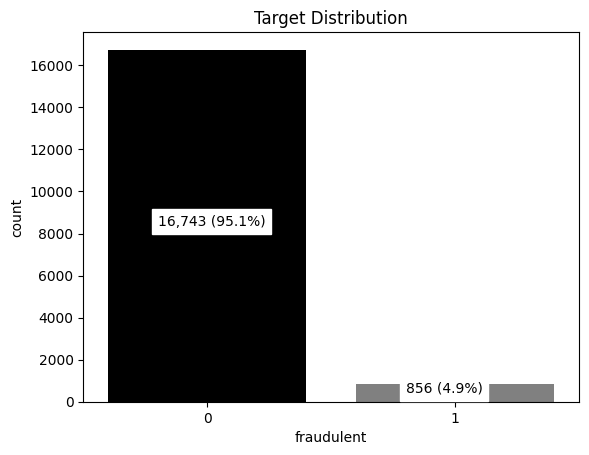

In [22]:
target_distribution(data=dd_raw_df,
                       target=target)

In [23]:
from scipy.stats import chi2_contingency

In [24]:
def categorical_variables_vs_target(data, categorical_variables, target, 
                                    crosstabs=True, crosstab_show_missing=False, crosstab_proportion=True, 
                                    col_proportion=True, plots=True, 
                                    vars_to_exclude_from_plots=[],plot_width=15,plot_height=20):
    categorical_variables = categorical_variables.copy()
    data = data.copy()
    categorical_variables = categorical_variables.copy()
    for i in categorical_variables:
        ct = pd.crosstab(columns=data[i],index=data[target])
        stat, p, dof, expected = chi2_contingency(ct) 
        print(f"\n{'-'*len(f'Chi-Square test between {i} & {target}')}")
        print(f'Chi-Square test between {i} & {target}')
        print(f"{'-'*len(f'Chi-Square test between {i} & {target}')}")
        print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN {target.upper()} & {i.upper()}")
        print(f"\nP-VALUE: {p}")
        print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")
    
    
    if plots == True:
        for rem in vars_to_exclude_from_plots:
            categorical_variables.remove(rem)
        cat_variables_length = len(categorical_variables)
        rows_in_plot = int(cat_variables_length / 2) if (cat_variables_length % 2 == 0) else (int(cat_variables_length / 2) + 1)
        r = c = 0
        fig,ax = plt.subplots(rows_in_plot,2,figsize=(plot_width,plot_height))
    

        if rows_in_plot > 1:
            for n,i in enumerate(categorical_variables):
                    ct = pd.crosstab(columns=data[i],index=data[target],normalize="columns")
                    ct.T.plot(kind="bar",stacked=True,color=["black","gray"],ax=ax[r,c])
                    ax[r,c].set_ylabel("% of observations")
                    ax[r,c].set_xlabel("")
                    ax[r,c].set_title(f'{i} vs {target}')
                    c+=1
                    if (n+1)%2==0:
                        r+=1
                        c=0
            if (cat_variables_length % 2) != 0:
                ax[r,c].axis("off")
        else:
            for n,i in enumerate(categorical_variables):
                    ct = pd.crosstab(columns=data[i],index=data[target],normalize="columns")
                    ct.T.plot(kind="bar",stacked=True,color=["black","gray"],ax=ax[c])
                    ax[c].set_ylabel("% of observations")
                    ax[c].set_xlabel("")
                    ax[c].set_title(f'{i} vs {target}')
                    c+=1
                    if (n+1)%2==0:
                        r+=1
                        c=0
            if cat_variables_length == 1:
                ax[1].axis('off')


        plt.show()
        
        
    if crosstabs == True:
        for i in categorical_variables:
            
            if crosstab_proportion == True:
                if col_proportion == True:
                    print(f"\n{'-'*len(f'Crosstab (Column-wise Proportion) between {i} & {target}')}")
                    print(f'Crosstab (Column-wise Proportion) between {i} & {target}')
                    if crosstab_show_missing == True:
                        data_1 = data.copy()
                        data_1.fillna('NaN/Missing',inplace=True)
                        ct = np.round(pd.crosstab(index=data_1[i],columns=data_1[target],normalize='columns') * 100, 2)
                    else:
                        ct = np.round(pd.crosstab(index=data[i],columns=data[target],normalize='columns') * 100, 2)
                    print(f"{'-'*len(f'Crosstab (Column-wise Proportion) between {i} & {target}')}")
                else:
                    print(f"\n{'-'*len(f'Crosstab (Row-wise Proportion) between {i} & {target}')}")
                    print(f'Crosstab (Row-wise Proportion) between {i} & {target}')
                    if crosstab_show_missing == True:
                        data_1 = data.copy()
                        data_1.fillna('NaN/Missing',inplace=True)
                        ct = np.round(pd.crosstab(index=data_1[i],columns=data_1[target],normalize='index') * 100, 2)
                    else:
                        ct = np.round(pd.crosstab(index=data[i],columns=data[target],normalize='index') * 100, 2)
                    print(f"{'-'*len(f'Crosstab (Row-wise Proportion) between {i} & {target}')}")
            else:
                print(f"\n{'-'*len(f'Crosstab between {i} & {target}')}")
                print(f'Crosstab between {i} & {target}')
                print(f"{'-'*len(f'Crosstab between {i} & {target}')}")
                if crosstab_show_missing == True:
                        data_1 = data.copy()
                        data_1.fillna('NaN/Missing',inplace=True)
                        ct = pd.crosstab(index=data_1[i],columns=data_1[target])
                else:
                    ct = pd.crosstab(index=data[i],columns=data[target])
            print(ct)

In [25]:
categorical_variables_vs_target(data=dd_raw_df,
                                    categorical_variables=categorical_variables,
                                    target=target,
                                    # vars_to_exclude_from_plots=['city'],
                                    plot_width=20,
                                    plot_height=35,
                                    col_proportion=False,
                                    plots=False,
                                    crosstab_show_missing=False)


------------------------------------------
Chi-Square test between title & fraudulent
------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & TITLE
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & TITLE

P-VALUE: 3.5022563223378587e-165
REJECT H0

---------------------------------------------
Chi-Square test between location & fraudulent
---------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & LOCATION
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & LOCATION

P-VALUE: 0.0
REJECT H0

-----------------------------------------------
Chi-Square test between department & fraudulent
-----------------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN FRAUDULENT & DEPARTMENT
H1: THERE IS RELATIONSHIP BETWEEN FRAUDULENT & DEPARTMENT

P-VALUE: 6.770599457599411e-220
REJECT H0

-------------------------------------------------
Chi-Square test between salary_range & fraudulent
----------------------------

In [26]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, MaxAbsScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif